In [7]:
# Import Necessary Libraries

import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import CESSIPy as SSI
from MRPy import MRPy
import copy
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [8]:
# Define Functions

def StabilizationDiagram(n, FN, title, ny):

    a_for = {'fontname':'Times New Roman','size':16}
    l_for = {'fontname':'Times New Roman','size':14}
    t_for = {'fontname':'Times New Roman','size':12}
    g_for = {'family'  :'Times New Roman','size':12}

    xt = np.arange(1, 40, 1)    
    
    plt.figure(figsize=(12,6))   

    for ii in range(n.shape[0]): 

        yi = n[ii]*np.ones(n[ii])  
        ko = plt.scatter(FN[ii,:n[ii]],yi,s=4,c='b')

    plt.xlim((0,40))
    plt.ylim((0,ny[-1]))
    plt.xticks(xt,**t_for)
    plt.yticks(ny,**t_for)
    plt.xlabel('f (Hz)',**l_for)
    plt.ylabel('Model Order',**l_for)
    plt.suptitle(title + ' Stabilization Diagram',**a_for)
    plt.legend([ko], ["Poles"], prop=g_for)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

def HVC(λ, fn, zt):
    
    λ_h = copy.deepcopy(λ)
    fn_h = copy.deepcopy(fn)
    zt_h = copy.deepcopy(zt)

    L = zt_h.shape[1]
    for i in range(len(zt_h)):
        j = 0
        while j < L:
            if zt_h[i,j] <= 0 or zt_h[i,j] > 0.2 and np.imag(λ[i][j]) == 0:
                λ_h[i,j] = np.nan
                fn_h[i,j] = np.nan
                zt_h[i,j] = np.nan
                j += 1
            else:
                j += 1
    return λ_h, fn_h, zt_h

def SVC(fn_h, zt_h, nmin, nmax, incr, b_hvc):
    
    fn_s = copy.deepcopy(fn_h)
    zt_s = copy.deepcopy(zt_h)
    
    dfn = np.full((int(((nmax-nmin)/incr)+1), fn_h.shape[1]),np.nan)
    dzt = np.full((int(((nmax-nmin)/incr)+1), fn_h.shape[1]),np.nan)
    
    tfn = np.full((int(((nmax-nmin)/incr)+1),fn_h.shape[1], fn_h.shape[1]),np.nan)
    tzt = np.full((int(((nmax-nmin)/incr)+1),fn_h.shape[1], fn_h.shape[1]),np.nan)

    I = M = fn_h.shape[1]
    
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        d = np.full((fn_h.shape[1], fn_h.shape[1]),np.nan) # distance between each pole in succeeding model order
        for i in range(I):
            if b_hvc[n][i] == True:
                for m in range(M):
                    if b_hvc[n+1][m] == True:
                        tfn[n][i][m] = abs(fn_h[n][i] - fn_h[n+1][m])
                        tzt[n][i][m] = abs(zt_h[n][i] - zt_h[n+1][m])
                for mm in range(M):
                    d[i][mm] = tfn[n][i][mm]
                # minimum distance
                if np.isnan(d[i]).all():
                    pass
                else:
                    m_min = np.nanargmin(d[i])
                    dfn[n][i] = tfn[n][i][m_min]
                    dzt[n][i] = tzt[n][i][m_min]
    
    bd = np.isnan(dfn)
    bd = ~bd
    pfn = np.array([])
    pzt = np.array([])
    L = 0
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        for i in range(I):
            if bd[n][i] == True:
                L += 1
                pfn = np.append(pfn,dfn[n][i])
                pzt = np.append(pzt,dzt[n][i])
    
    hfn, _fn = stats.boxcox(pfn)
    hzt, _zt = stats.boxcox(pzt)
    
    zfn = stats.zscore(hfn)
    zzt = stats.zscore(hzt)

    cp = pd.DataFrame({'Frequencies': zfn,'Damping': zzt})
    
    init_centroids = np.array([[-3,-3],[3,3]])
    km = KMeans(n_clusters = 2, init = init_centroids, random_state=0, n_init = 1)
    cp['cluster'] = km.fit_predict(cp[['Frequencies','Damping']])
    
    palette = {0: 'red', 1: 'green'}
    sns.pairplot(cp, hue='cluster', palette=palette)
    plt.show()
    
    # Change unstable mode values to NaN
    
    cluster = cp['cluster'].values
    print(cluster.shape)
    l = 0
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        for i in range(I):
            if bd[n][i] == True:
                if cluster[l] == 1:
                    fn_s[n][i] = np.nan
                    zt_s[n][i] = np.nan
                l += 1
            
    return fn_s, zt_s 

def GroupModes(fn_s, zt_s, nmin, nmax, incr, b_svc):
    
    F = np.array([])
    
    d_min = np.full((int(((nmax-nmin)/incr)+1), fn_s.shape[1]),np.nan)
    tfn = np.full((int(((nmax-nmin)/incr)+1),fn_s.shape[1], fn_s.shape[1]),np.nan)
    
    I = M = fn_s.shape[1]
    
    L = 0
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        for i in range(I):
            if b_svc[n][i] == True:
                L += 1
                F = np.append(F,fn_s[n][i])
    
    pole = pd.DataFrame({'Frequencies': F})

    # Compute the distance matrix using the absolute difference

    dist_matrix = np.abs(F.reshape(-1, 1) - F.reshape(1, -1))
    
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        d = np.full((fn_s.shape[1], fn_s.shape[1]),np.nan) # distance between each pole in succeeding model order
        for i in range(I):
            if b_svc[n][i] == True:
                for m in range(M):
                    if b_svc[n+1][m] == True:
                        tfn[n][i][m] = abs(fn_s[n][i] - fn_s[n+1][m])
                for mm in range(M):
                    d[i][mm] = tfn[n][i][mm]     
                if np.isnan(d[i]).all():
                    pass
                else:
                    m_min = np.nanargmin(d[i])
                    d_min[n][i] = tfn[n][i][m_min]
    
    bdmin = np.isnan(d_min)
    bdmin = ~bdmin
    d_minv = np.array([])
    LL = 0
    for n in range(0, int(((nmax-nmin)/incr)), 1):
        for i in range(I):
            if bdmin[n][i] == True:
                LL += 1
                d_minv = np.append(d_minv,d_min[n][i])
                
    Z = linkage(dist_matrix, method='average')
    
    shape, loc, scale = stats.weibull_min.fit(d_minv, floc=0)

    threshold = stats.weibull_min.ppf(0.95, shape, loc, scale)
    
    # Plot the dendrogram
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.xticks([])
    plt.xlabel('Height [-]')
    plt.ylabel('Pole Number [-]')
    dendrogram(Z, color_threshold = threshold)
    plt.show()
    
    clusters = fcluster(Z, t = threshold, criterion='distance')
    
    pole['hCluster'] = clusters

    # Get unique cluster labels and their count
    unique_labels, label_counts = np.unique(clusters, return_counts=True)

    dfC = pd.DataFrame({'Labels': unique_labels, 'Counts': label_counts})
    
    km = KMeans(init = 'k-means++', n_init = 30, n_clusters = 2)
    dfC['cluster'] = km.fit_predict(dfC[['Counts']])
    
    palette = {0: 'red', 1: 'green'}
    sns.pairplot(dfC, hue='cluster', palette=palette)
    plt.show()
    
    maxCluster = dfC['Counts'].idxmax()
    chosenCluster = dfC.loc[maxCluster, 'cluster']
    print("Chosen Cluster: ", end="")
    print(chosenCluster)
    
    pole['kmCluster'] = 0
    
    for i1, r1 in pole.iterrows():
        for i2, r2 in dfC.iterrows():
            if r1['hCluster'] == r2['Labels']:
                if r2['cluster'] == chosenCluster:
                    pole.at[i1, 'kmCluster'] = 1
    
    pole = pole[pole['kmCluster'] == 1]
    means = pole.groupby('hCluster')['Frequencies'].mean()
    std_dev = pole.groupby('hCluster')['Frequencies'].std()
    
    print(str(means)+'\u00B1'+str(std_dev)) 
        

Enter Filename: Brodie
Enter Number of Datapoints: 46000
Enter Channel Number (1st channel = 0): 0
Current Sampling Frequency of Inputted Data: 50 Hz
To downsample, enter a lower sampling frequency. If not, enter the current sampling frequency.
Enter Sampling Frequency: 50


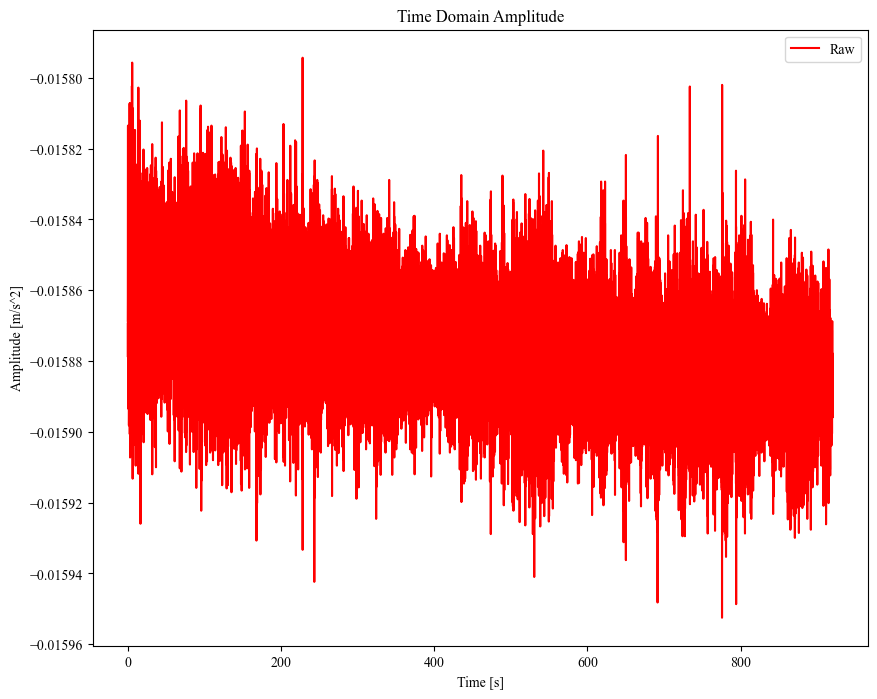

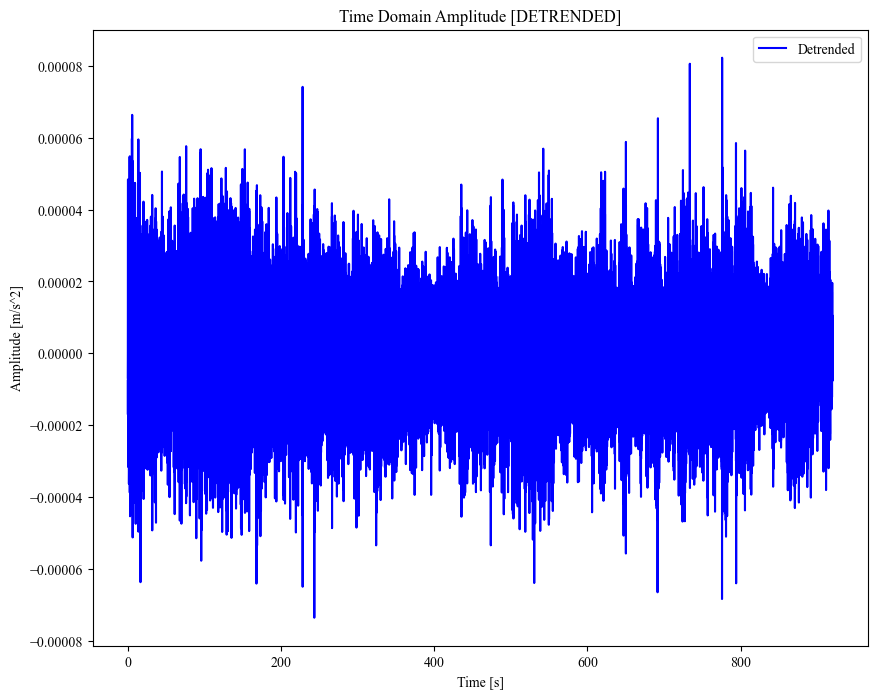

In [9]:
# Preprocess and display Acceleration Data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

filename = input("Enter Filename: ")
y = MRPy.from_file(filename, form = 'invh')

N_end = int(input("Enter Number of Datapoints: "))
channel = int(input("Enter Channel Number (1st channel = 0): "))
N_start = 0
N = N_end - N_start
yk = MRPy(y[channel,N_start:N_end], fs = y.fs)

yyk = np.asarray(yk[0])

# Resampling
fs_orig = int(y.fs)
print("Current Sampling Frequency of Inputted Data: ", end="")
print(int(y.fs), end="")
print(" Hz")
print("To downsample, enter a lower sampling frequency. If not, enter the current sampling frequency.")
fs_new = int(input("Enter Sampling Frequency: "))

t = np.arange(N)/yk.fs

if fs_orig > fs_new:
    print("Downsample needed...")
    yyk = signal.resample(x = yyk, num = int(N*fs_new/fs_orig))
    yyk = np.reshape(yyk, (1, int(N*fs_new/fs_orig)))
    tr = np.arange(N*fs_new/fs_orig)/fs_new
    ykd = signal.detrend(yyk)
    ykd = np.reshape(ykd, (1, int(N*fs_new/fs_orig)))
    fss = fs_new
    label2 = 'Downsampled and Detrended'
else: 
    tr = t
    ykd = signal.detrend(yyk)
    ykd = np.reshape(ykd, (1, N))
    fss = y.fs
    label2 = 'Detrended'
    
# kurtosis_value = stats.kurtosis(ykd, fisher=False)
# print("Kurtosis: ", kurtosis_value)

plt.figure(figsize=(10,8))
plt.plot(t, yk[0], 'r-', label='Raw')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [m/s^2]')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Time Domain Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(tr, ykd[0], 'b-', label=label2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [m/s^2]')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Time Domain Amplitude [DETRENDED]')
plt.legend()
plt.show()

# System Identification

Enter minimum model number: 2
Enter maximum model number: 110
Default value of i = nmax


C:\Users\Ranz Gabor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


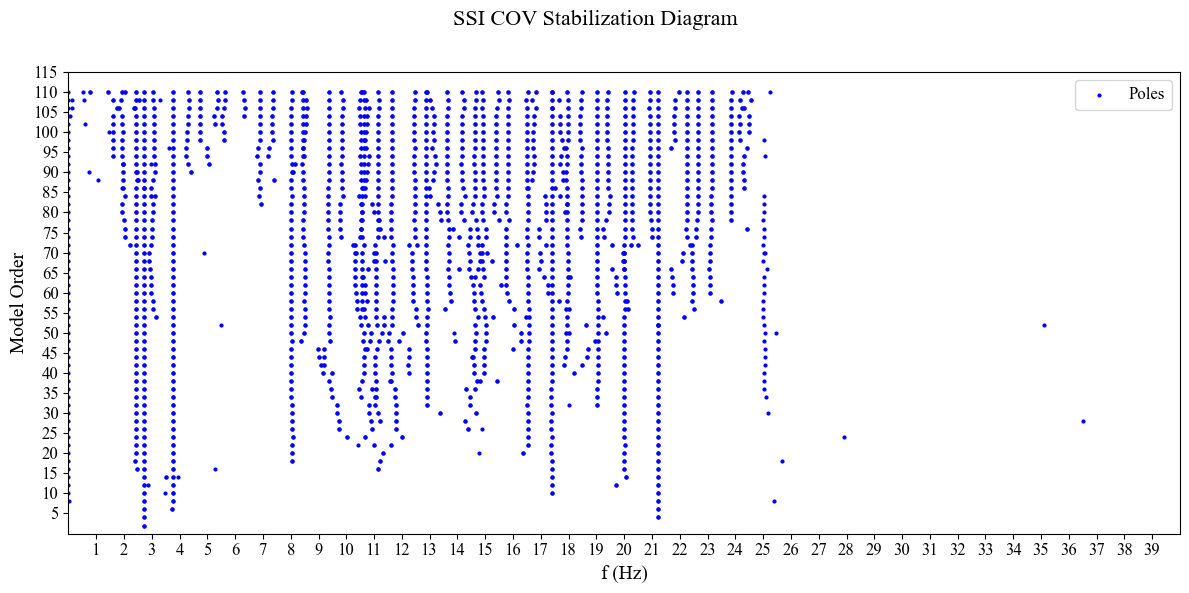

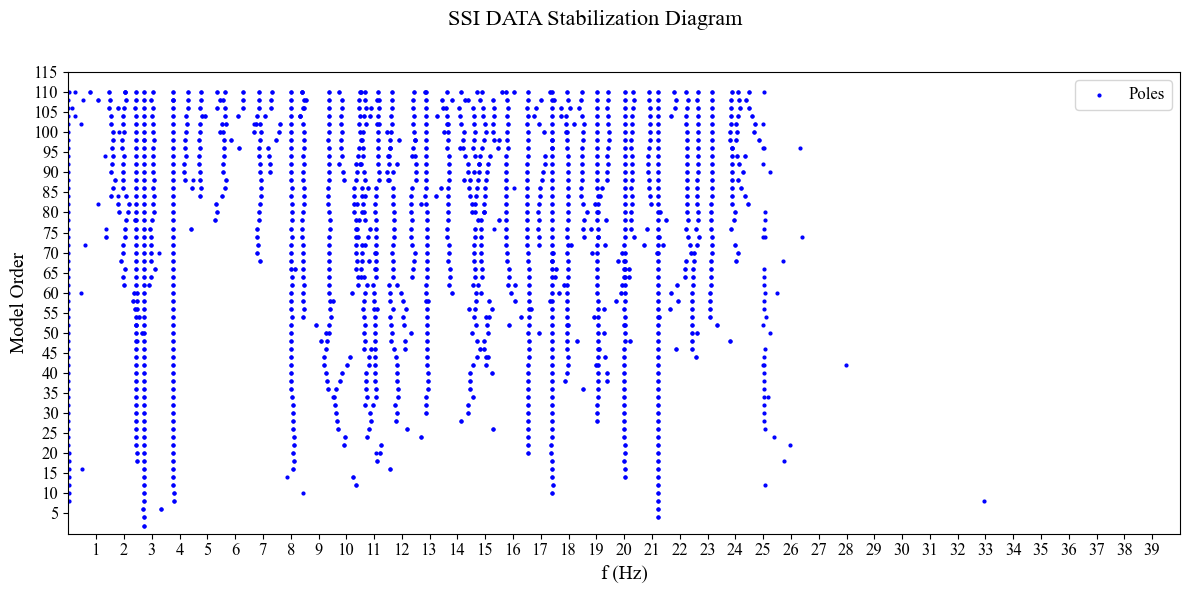

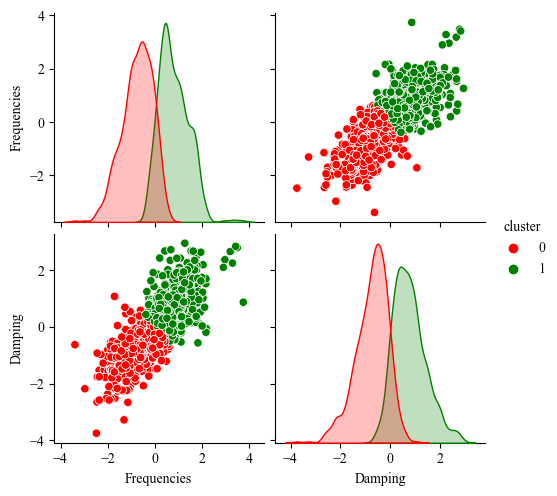

(2256,)


C:\Users\Ranz Gabor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


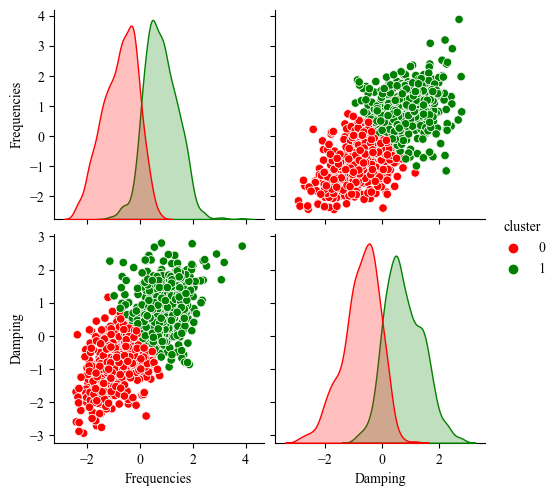

(2416,)


C:\Users\Ranz Gabor\AppData\Local\Temp\ipykernel_22920\549447871.py:167: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')


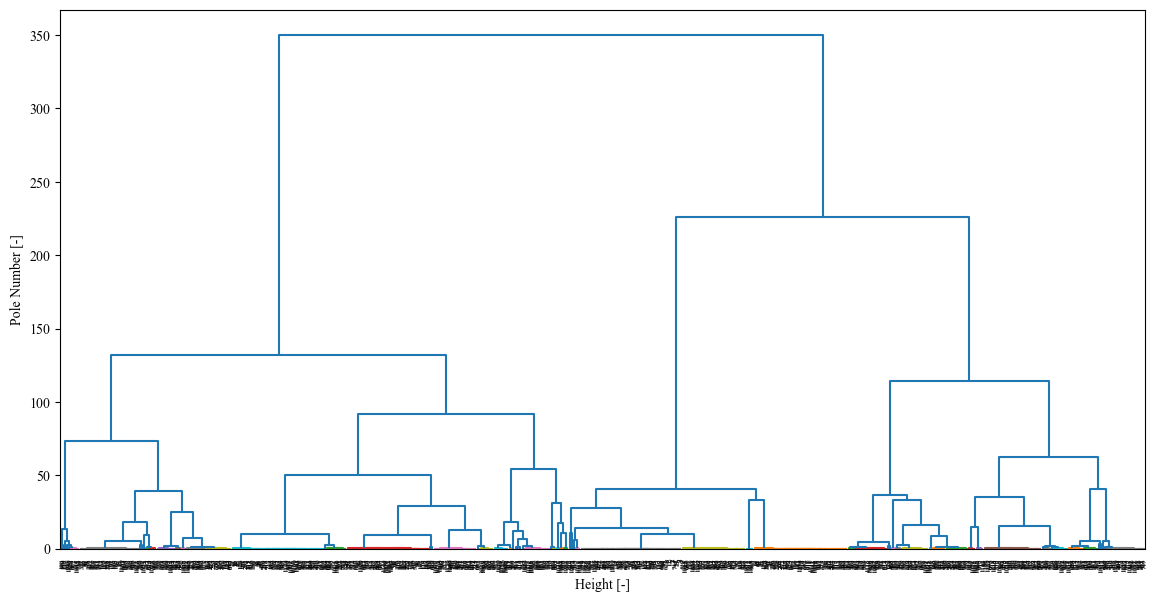

C:\Users\Ranz Gabor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


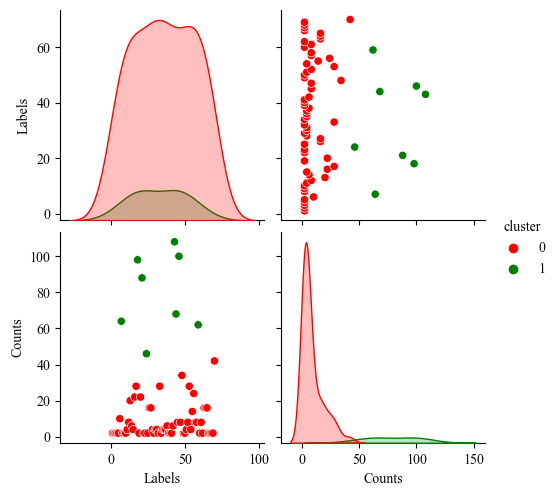

Chosen Cluster: 1
hCluster
7     17.388857
18    21.219702
21    20.010269
24    19.029787
43     2.711139
44     2.421889
46     3.758442
59     8.024789
Name: Frequencies, dtype: float64±hCluster
7     0.005655
18    0.001068
21    0.005355
24    0.006047
43    0.001237
44    0.004517
46    0.001509
59    0.006829
Name: Frequencies, dtype: float64


C:\Users\Ranz Gabor\AppData\Local\Temp\ipykernel_22920\549447871.py:167: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')


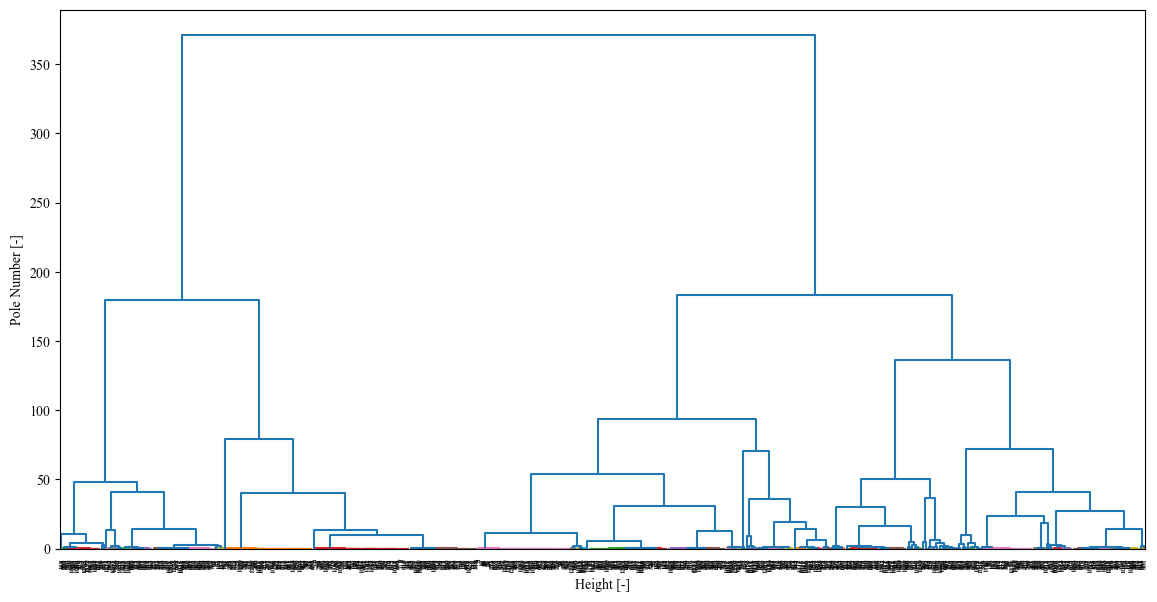

C:\Users\Ranz Gabor\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


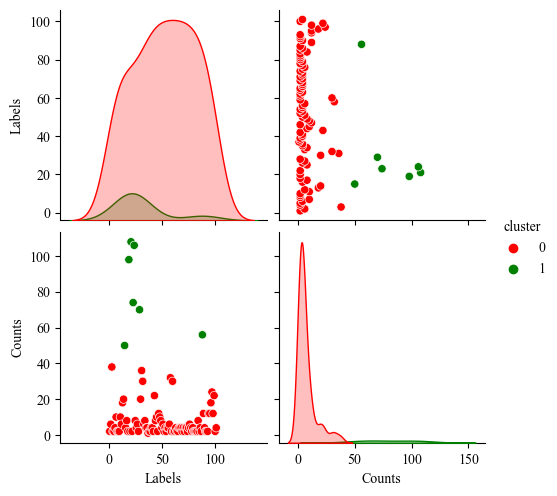

Chosen Cluster: 1
hCluster
15     8.024706
19     3.757563
21     2.709736
23     2.429613
24    21.219437
29    20.014054
88    17.387298
Name: Frequencies, dtype: float64±hCluster
15    0.005500
19    0.001260
21    0.001721
23    0.005057
24    0.001660
29    0.003582
88    0.003787
Name: Frequencies, dtype: float64


In [10]:
# Apply System Identification Methods and Clustering

# Time-Domain
ykd = MRPy(ykd, fs = int(fss))
# yk = MRPy(yk, fs = fss)
# print(fss)
ykd = SSI.rearrange_data(ykd, [0])
# yk = SSI.rearrange_data(yk, [0])
# i = 100

# tol = np.array(([0.01, 0, 35],
#                 [0.10, 0,.10],
#                 [1   , 0,  1]))

nmin = int(input("Enter minimum model number: "))
nmax = int(input("Enter maximum model number: "))
incr = 2
print("Default value of i = nmax")
i = nmax

# SSI COV

λC, FNC, ZTC, VVC = SSI.SSI_COV_iterator(ykd, i, nmin, nmax, incr)
# stbC = SSI.stabilization_diagram(FNC, ZTC, VVC, 'SSI COV', tol = tol)
# FNCR, ZTCR, VVCR = SSI.stable_modes(FNC, ZTC, VVC, stbC, tol = 0.01, spo = 6)
# print(FNCR)
# SSI DATA

λD, FND, ZTD, VVD = SSI.SSI_DATA_iterator(ykd, i, nmin, nmax, incr)
# stbD = SSI.stabilization_diagram(FND, ZTD, VVD, 'SSI COV', tol = tol)
# FNDR, ZTDR, VVDR = SSI.stable_modes(FND, ZTD, VVD, stbD, tol = 0.01, spo = 6)
# print(FNDR)
# Stabilization Diagrams

n = np.arange(nmin,nmax+incr,incr)
ny = np.arange(5, nmax+10, 5)
titleCOV = "SSI COV"
titleDATA = "SSI DATA"

StabilizationDiagram(n, FNC, titleCOV, ny)
StabilizationDiagram(n, FND, titleDATA, ny)

# HVC 

λC_HVC, FNC_HVC, ZTC_HVC = HVC(λC, FNC, ZTC)
bc_hvc = np.isnan(FNC_HVC)    # bool
bc_hvc = ~bc_hvc        # True if there is value, False if NaN

λD_HVC, FND_HVC, ZTD_HVC = HVC(λD, FND, ZTD)
bd_hvc = np.isnan(FND_HVC)
bd_hvc = ~bd_hvc        # True if there is value, False if NaN

# SVC

# KMeans Clustering

FNC_SVC, ZTC_SVC = SVC(FNC_HVC, ZTC_HVC, nmin, nmax, incr, bc_hvc)
bc_svc = np.isnan(FNC_SVC)
bc_svc = ~bc_svc

FND_SVC, ZTD_SVC = SVC(FND_HVC, ZTD_HVC, nmin, nmax, incr, bd_hvc)
bd_svc = np.isnan(FND_SVC)
bd_svc = ~bd_svc

# Hierarchical Clustering
GroupModes(FNC_SVC, ZTC_SVC, nmin, nmax, incr, bc_svc)
GroupModes(FND_SVC, ZTD_SVC, nmin, nmax, incr, bd_svc)